In [1]:
import torch
from torchvision import transforms
from dataset3 import CityDataset
import torch.nn.functional as F
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net
from nn_model3 import Sgmt_UNet
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
import torch.nn.functional as F
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [2]:
bs = 5
# sz = (320,240)
sz = (256,256)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndSgmt(sz),
    RandomHorizontalFlip(),
    ImgAndSgmtToTensor(),
    NormalizeImg(mean, std)
])

In [3]:
# ds = NYUDataset('data/', tfms)
# dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

ds = CityDataset(tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

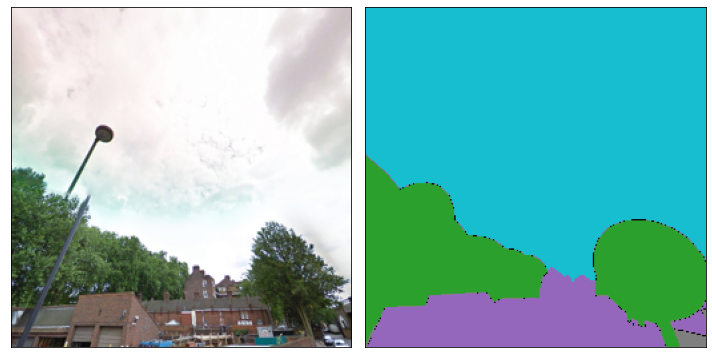

In [4]:
i = 4
plot_utils.plot_image_sgmt(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))
# ds[i][1]
#sample_batch = iter(dl).next()
#img, depth = sample_batch

In [5]:
ds[0][1].shape
# new_img_PIL = transforms.ToPILImage()(ds[0][0]).convert('RGB')
# new_img_PIL.show() 
# print(ds[0][1])


torch.Size([256, 256])

In [6]:
# model = Net()
# model.to(device)
model = Sgmt_UNet()
model.to(device)

Sgmt_UNet(
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block3_16): UNetConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_block16_32): UNetConvBlock(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_block32_64): UNetConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3)

In [7]:
model.load_state_dict(torch.load('model_sgmt.ckpt', map_location="cpu"))
#model_utils.freeze_all_layers(model.VGG)
#model_utils.freeze_all_layers(model.Scale_1)
#model_utils.freeze_all_layers(model.Scale_2)

<All keys matched successfully>

In [13]:
model.train()
n_epochs = 200
# lr = 0.0000005
lr = 0.00005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        preds=F.softmax(preds)
        # lossf = torch.nn.BCELoss()
        lossf = torch.nn.CrossEntropyLoss()
        loss = lossf(preds,labels)
        # loss = model_utils.depth_loss(preds, labels) 
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        if e%20==10:
            torch.save(model.state_dict(),'model_sgmt.ckpt')                                               
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

oss: 1.0830
Epoch [79/200], Iteration [20/232], Loss: 0.9741
Epoch [79/200], Iteration [30/232], Loss: 0.9647
Epoch [79/200], Iteration [40/232], Loss: 0.9552
Epoch [79/200], Iteration [50/232], Loss: 0.9860
Epoch [79/200], Iteration [60/232], Loss: 1.0818
Epoch [79/200], Iteration [70/232], Loss: 1.2080
Epoch [79/200], Iteration [80/232], Loss: 0.9843
Epoch [79/200], Iteration [90/232], Loss: 1.0905
Epoch [79/200], Iteration [100/232], Loss: 1.3708
Epoch [79/200], Iteration [110/232], Loss: 0.9383
Epoch [79/200], Iteration [120/232], Loss: 0.9497
Epoch [79/200], Iteration [130/232], Loss: 0.9564
Epoch [79/200], Iteration [140/232], Loss: 1.1269
Epoch [79/200], Iteration [150/232], Loss: 1.0314
Epoch [79/200], Iteration [160/232], Loss: 0.9991
Epoch [79/200], Iteration [170/232], Loss: 0.9849
Epoch [79/200], Iteration [180/232], Loss: 0.9813
Epoch [79/200], Iteration [190/232], Loss: 1.0210
Epoch [79/200], Iteration [200/232], Loss: 1.0109
Epoch [79/200], Iteration [210/232], Loss: 0.9

KeyboardInterrupt: 

In [14]:
torch.save(model.state_dict(),'model_sgmt.ckpt')

In [14]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    # preds =F.sigmoid( model(img.to(device)) )
    preds = model(img.to(device))
    # print(torch.argmax(F.softmax(preds)[0], dim=1))  .detach().numpy()[0]
    preds=F.softmax(preds)
    print(preds)
    preds = torch.argmax(preds.squeeze(), dim=1)
    print(preds)

tensor([[[[3.2220e-02, 4.6103e-03, 1.3199e-03,  ..., 9.9911e-01,
           9.9708e-01, 9.6999e-01],
          [2.1431e-03, 5.8219e-05, 6.5309e-06,  ..., 9.9998e-01,
           9.9988e-01, 9.9630e-01],
          [3.7618e-04, 3.4684e-06, 1.7899e-07,  ..., 1.0000e+00,
           9.9998e-01, 9.9864e-01],
          ...,
          [1.3706e-10, 5.1293e-17, 6.3339e-20,  ..., 2.8569e-21,
           4.6019e-19, 2.7609e-12],
          [7.4145e-10, 1.0356e-15, 3.1698e-18,  ..., 3.3848e-19,
           3.4586e-17, 3.5672e-11],
          [1.4119e-06, 1.5389e-10, 3.6627e-12,  ..., 1.0606e-12,
           1.8952e-11, 1.1478e-07]],

         [[9.2553e-01, 9.9228e-01, 9.9793e-01,  ..., 8.9256e-04,
           2.9075e-03, 2.8739e-02],
          [9.9298e-01, 9.9984e-01, 9.9997e-01,  ..., 1.9113e-05,
           1.1563e-04, 3.6698e-03],
          [9.9780e-01, 9.9997e-01, 1.0000e+00,  ..., 2.9708e-06,
           2.4510e-05, 1.3543e-03],
          ...,
          [3.2701e-03, 1.0870e-04, 1.8949e-05,  ..., 1.6369

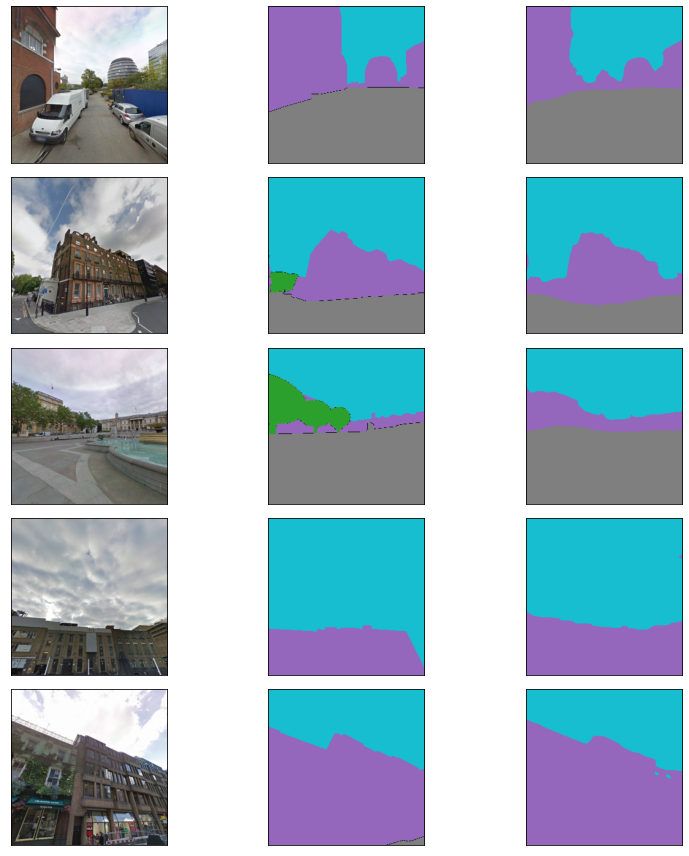

In [15]:
# print(preds.cpu()[0][0].shape)
# img2 = transforms.ToPILImage()(preds.cpu()[0][0])
# img2.show()
# print(img[0].shape)
# img3 = transforms.ToPILImage()(img[0])
# img3.show()
# print(depth[0].shape)
# img4 = transforms.ToPILImage()(depth[0])
# img4.show()
# output=preds.cpu()
# output = output.detach().numpy()
# plt.imsave('pred.png', np.transpose(output[0][0], (0, 1)))
# output=depth
# output = output.detach().numpy()
# plt.imsave('GTdepth.png', np.transpose(output[0], (0, 1)))
# preds =F.sigmoid( preds) 
# print(preds)

plot_utils.plot_model_predictions_on_sample_batch_2(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

In [18]:
test_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [19]:
import PIL
from PIL import Image

im = Image.open('test.jpg').rotate(180)
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

In [20]:
pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()       # -0.660375
pred_numpy_arr = (pred_numpy_arr/pred_numpy_arr.max())*255   # max = 2.1548061, brings scale to 0-255  
pred_numpy_arr = pred_numpy_arr.astype('uint8')

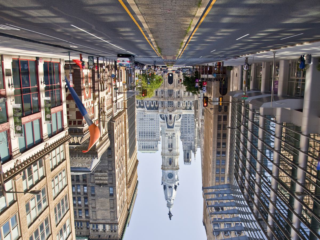

In [20]:
im.resize((320,240), resample=PIL.Image.BILINEAR)

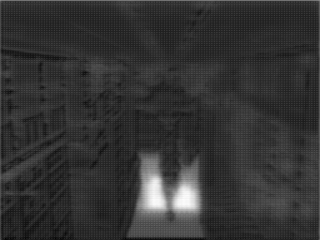

In [22]:
Image.fromarray(pred_numpy_arr, mode = 'L').resize((320, 240))

In [24]:
# T, P = transforms.ToTensor(), transforms.ToPILImage()
# dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(ds[10], unnormalize, T, P)

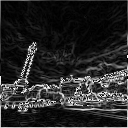

In [25]:
# P(g)

In [37]:
# from IPython.display import FileLink
# FileLink('all-scales-trained.ckpt')

/home/anxing/work/GITHUB/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network/all-scales-trained.ckpt